# Project 3: 'Image Analysis'
## First Year Project  
### ITU, Spring 2021

This notebook contains all the code developed to explore, wrangle and analyse the raw data sets for our project, 'Image Analysis'.

Contributors:  
- Andy Bao Nguyen (anbn)
- Florian Micliuc (flmi)
- Mattias Wohlert 
- Sofia Elena Terenziani (sote)

Created: 06-04-2021 

Last modified:

### Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
import random
import cv2
import PIL
from PIL import Image

### Constants

In [41]:
path_images = '../../data/raw/example_image'
path_masks = '../../data/raw/example_segmentation'

file_data = '../../data/raw/example_ground_truth.csv'
file_features = '../../data/features/features.csv'

### Import raw data 

In [3]:
df_file_data = pd.read_csv(file_data)
df_file_features = pd.read_csv(file_features)

In [4]:
num_images = len(df_file_data['image_id'])

In [ ]:
#import images

## Task 0: Data Exploration 

In [45]:
# Extract image IDs and labels from the data
image_id = list(df_file_data['image_id'])
is_melanoma = np.array(df_file_data['melanoma'])
is_keratosis = np.array(df_file_data['seborrheic_keratosis'])

In [ ]:
#merging the datasets 
#metadata = pd.DataFrame(dataraw["metadata"])
#features = pd.DataFrame(dataraw["features"])
#merged_data = metadata.merge(features, left_on = ["image_id"], right_on = ["id"])
#merged_data = merged_data.drop(["id"], axis =1)
#print(merged_data)

In [ ]:
#mask 
#melanoma = (is_melanoma == 1.0) & (merged_data["seborrheic_keratosis"] == 0.0)
#mask_keratosis = (merged_data["melanoma"] == 0.0) & (merged_data["seborrheic_keratosis"] == 1.0)
#mask_none = (merged_data["melanoma"] == 0.0) & (merged_data["seborrheic_keratosis"] == 0.0)

#merged_melanoma = merged_data[mask_melanoma]
#merged_keratosis = merged_data[mask_keratosis]
#merged_none = merged_data[mask_none]

In [ ]:
#images id and actual images lists 
#melanoma_images_id = [i for i in merged_melanoma["image_id"]]
#keratosis_images_id = [i for i in merged_keratosis["image_id"]]
#none_images_id = [i for i in merged_none["image_id"]]

#melanoma_images = [i for i in dataraw["images_filename"] for j in melanoma_images_id if j in i]
#keratosis_images = [i for i in dataraw["images_filename"] for j in keratosis_images_id if j in i]
#none_images = [i for i in dataraw["images_filename"] for j in none_images_id if j in i]

## Task 1: Implement two features 

In [ ]:
#Make empty arrays to store features
features_area = np.empty([num_images,1])
features_area[:] = np.nan
features_perimeter = np.empty([num_images,1])
features_perimeter[:] = np.nan

In [ ]:
features_symmetry = np.empty([num_images,1])
features_area[:] = np.nan

### Perimiter 

In [ ]:
def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)

    return area, perimeter

In [ ]:
for i in np.arange(num_images):
    # Define filenames related to this image
    file_image = path_images + os.sep + image_id[i] + '.jpg'
    file_mask = path_masks + os.sep + image_id[i] + '_segmentation.png'
    
    # Read the images with these filenames
    im = plt.imread(file_image)
    mask = plt.imread(file_mask)
    # Measure features (custom made function)
    im = plt.imread(file_image)
    mask = plt.imread(file_mask)
    a, p = measure_area_perimeter(mask)
    
    # Store in the variables we created before
    features_area[i,0] = a
    features_perimeter[i,0] = p

### Symmetry

In [42]:
def symmetry(im): 
    #Read image
    im = plt.imread(im)
    
    #Crop the picture
    #Center of the shape is the center of the image
    #The borders of the shape are the borders of the image
    y_nonzero, x_nonzero = np.nonzero(im)
    im = im[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    
    #Cut the image in halves 
    #Find the point of cutoff
    height, width = im.shape
    width_cutoff = width // 2
    height_cutoff = height // 2
    
    #Cut the image vertically and horizontally in two 
    imVertical1 = im[:, :width_cutoff]
    imVertical2 = im[:, width_cutoff:]
    imHorizontal1 = im[:height_cutoff, :]
    imHorizontal2 = im[height_cutoff:, :]
    
    #Flip image 
    #Interting one of the images both vertically and horizontally   
    indexerVertical = [slice(None)] * imVertical2.ndim
    indexerHorizontal = [slice(None)] * imHorizontal2.ndim
    indexerVertical[1] = slice(None, None, -1)
    indexerHorizontal[0] = slice(None, None, -1) 
    imVertical2 = imVertical2[tuple(indexerVertical)]
    imHorizontal2 = imHorizontal2[tuple(indexerHorizontal)]

    #Cut the biggest image, if the images don't have the same shape 
    #This can happen if the shape of the original shape was an odd number 
    imVertical2 = imVertical2[0:imVertical1.shape[0], 0:imVertical1.shape[1]]
    imHorizontal2 = imHorizontal2[0:imHorizontal1.shape[0], 0:imHorizontal1.shape[1]]

    img_bwxVertical = cv2.bitwise_xor(imVertical1,imVertical2)
    img_bwxHorizontal = cv2.bitwise_xor(imHorizontal1,imHorizontal2)
    
    areaVertical = np.sum(img_bwxVertical == 1)
    areaHorizontal = np.sum(img_bwxHorizontal == 1)
    
    res = (areaVertical + areaHorizontal) / 2
    return res 

In [43]:
print(symmetry('../../Data/raw/example_segmentation/ISIC_0014624_segmentation.png'))
print(symmetry('../../Data/raw/circ_mask.png'))

85668.5
434.0


In [46]:
#NOT DONE YET!
for i in np.arange(num_images):
    # Define filenames related to this image
    file_image = path_images + os.sep + image_id[i] + '.jpg'
    file_mask = path_masks + os.sep + image_id[i] + '_segmentation.png'
    
    # Read the images with these filenames
    im = plt.imread(file_image)
    mask = plt.imread(file_mask)
    # Measure features (custom made function)
    symmetry = symmetry(im)
    
    # Store in the variables we created before
    features_symmetry[i,0] = symmetry

ValueError: fname must be a PathLike or file handle

In [ ]:
#This is another way of doing it 
#img_bwa = cv2.bitwise_and(s1,flipped_vertical)
#img_bwo = cv2.bitwise_or(s1,flipped_vertical)
#img_bwx = cv2.bitwise_xor(s1,flipped_vertical)

#cv2.imshow("Bitwise AND of Image 1 and 2", img_bwa)
#cv2.imshow("Bitwise OR of Image 1 and 2", img_bwo)
#plt.imshow(img_bwx, cmap='gray')
#number_of_white_pix_im = np.sum(img_bwx == 1)
#print(number_of_white_pix_im)

In [ ]:
#Find symmetric difference 
#Compute intersection and union of the two images both vertically and horizontally 
#intersectionVertical = cv2.bitwise_and(imVertical1,imVertical2)
#intersectionHorizontal = cv2.bitwise_and(imHorizontal1,imHorizontal2)
#unionVertical = cv2.bitwise_or(imVertical1,imVertical2)
#unionHorizontal = cv2.bitwise_or(imHorizontal1,imHorizontal2)
#Count the number of non zero for both intersection and union 
#symmetry_vertical = cv2.countNonZero(intersectionVertical) - cv2.countNonZero(unionVertical)
#symmetry_horizontal = cv2.countNonZero(intersectionHorizontal)/cv2.countNonZero(unionHorizontal)
    
#Symmetric difference 
#symmetry = (symmetry_vertical + symmetry_horizontal) / 2

#### Example

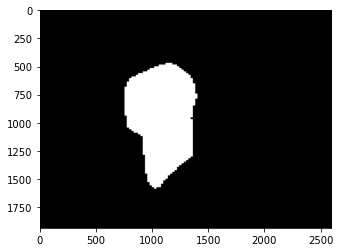

In [47]:
image_mask = plt.imread('../../Data/raw/example_segmentation/ISIC_0014624_segmentation.png')
plt.imshow(image_mask, cmap='gray')

#im = plt.imread("../../Data/raw/example_image/ISIC_0014624.jpg")
#plt.imshow(im)

https://stackoverflow.com/questions/62970301/testing-for-asymetry-image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

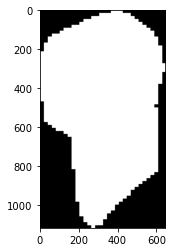

In [48]:
#Function to crop images 
def crop(image):
    y_nonzero, x_nonzero = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
image_mask2 = crop(image_mask)
plt.imshow(image_mask2, cmap='gray')
image_mask2

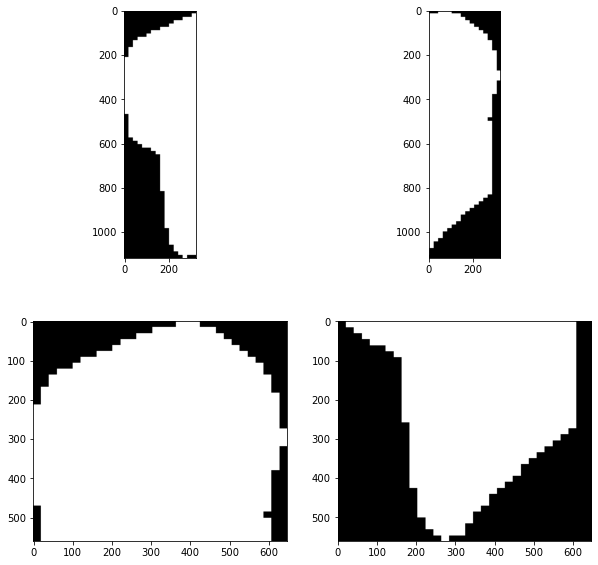

In [49]:
from PIL import Image
height, width = image_mask2.shape

# Cut the image in half
#If shape of image is a flot, it must be interpreded as integer, as the slice indices must be integers  

width_cutoff = width // 2
height_cutoff = height // 2

s1 = image_mask2[:, :width_cutoff]
s2 = image_mask2[:, width_cutoff:]
s3 = image_mask2[:height_cutoff, :]
s4 = image_mask2[height_cutoff:, :]

fig, axes = plt.subplots(2, 2, figsize =(10,10))
axes[0,0].imshow(s1, cmap='gray')
axes[0,1].imshow(s2, cmap='gray')
axes[1,0].imshow(s3, cmap='gray')
axes[1,1].imshow(s4, cmap='gray')

In [50]:
def flip(m, axis):
    indexer = [slice(None)] * m.ndim
    indexer[axis] = slice(None, None, -1)
    return m[tuple(indexer)]

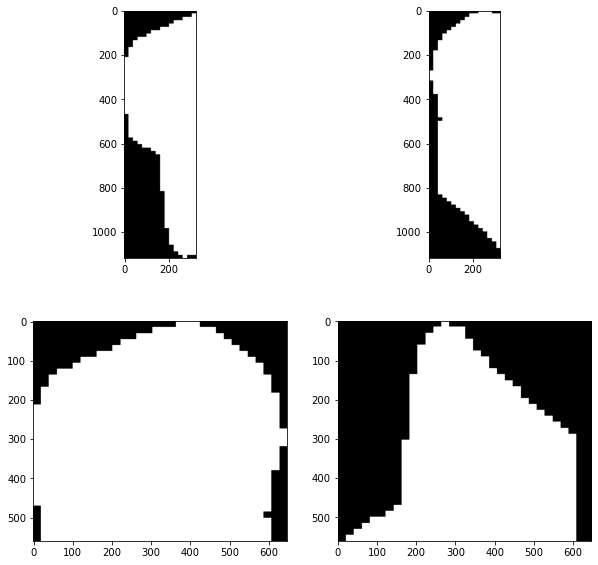

In [54]:
flipped_vertical = flip(s2, 1)
flipped_horizontal = flip(s4, 0)

fig, axes = plt.subplots(2, 2, figsize =(10,10))
axes[0,0].imshow(s1, cmap='gray')
axes[0,1].imshow(flipped_vertical, cmap='gray')
axes[1,0].imshow(s3, cmap='gray')
axes[1,1].imshow(flipped_horizontal, cmap='gray')

In [61]:
#change shape
flipped_vertical = flipped_vertical[0:s1.shape[0], 0:s1.shape[1]]
flipped_horizontal = flipped_horizontal[0:s3.shape[0], 0:s3.shape[1]]

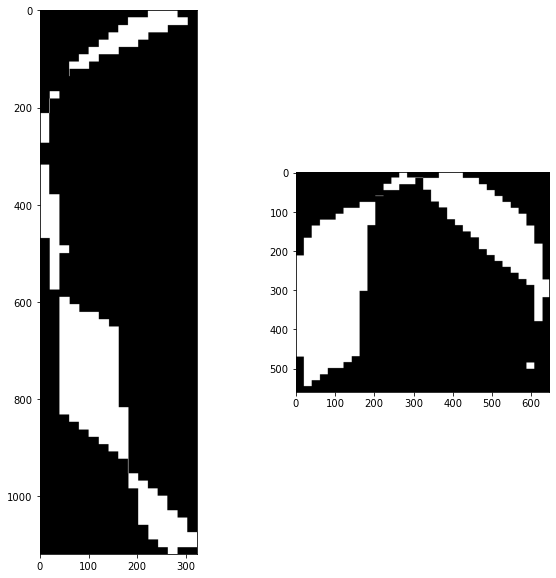

In [65]:
#img_bwa = cv2.bitwise_and(s1,flipped_vertical)
#img_bwo = cv2.bitwise_or(s1,flipped_vertical)
img_bwx = cv2.bitwise_xor(s1,flipped_vertical)
img_bwx2 = cv2.bitwise_xor(s3,flipped_horizontal)

#cv2.imshow("Bitwise AND of Image 1 and 2", img_bwa)
#cv2.imshow("Bitwise OR of Image 1 and 2", img_bwo)

fig, axes = plt.subplots(1, 2, figsize =(10,10))
axes[0].imshow(img_bwx, cmap='gray')
axes[1].imshow(img_bwx2, cmap='gray')

In [73]:
areaAsymmetryVertical = np.sum(img_bwx == 1)
areaAsymmetryHorizontal = np.sum(img_bwx2 == 1)

print(areaAsymmetryVertical)
print(areaAsymmetryHorizontal)

symmetry_all = (areaAsymmetryVertical + areaAsymmetryHorizontal) / 2
print(symmetry_all)

60716
110621
85668.5


In [25]:
image_mask_circle = plt.imread('../../Data/raw/circ_mask.png')
image_mask_circle = crop(image_mask_circle)

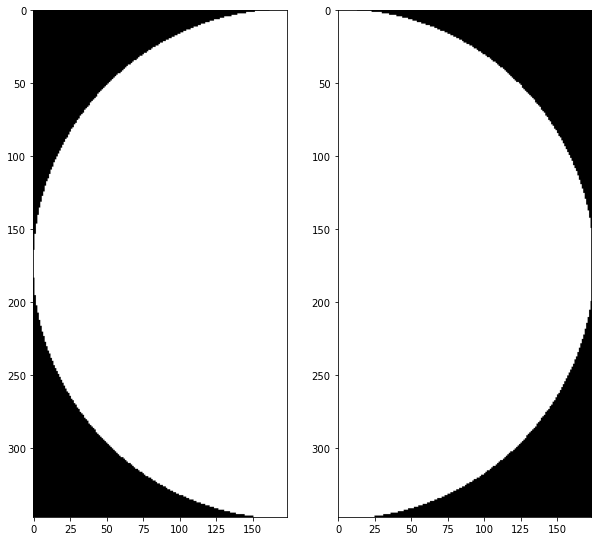

In [28]:
from PIL import Image
height, width = image_mask_circle.shape

# Cut the image in half
#If shape of image is a flot, it must be interpreded as integer, as the slice indices must be integers  

width_cutoff = width // 2

s1_cir = image_mask_circle[:, :width_cutoff]
s2_cir = image_mask_circle[:, width_cutoff:]
    

fig, axes = plt.subplots(1, 2, figsize =(10,10))
axes[0].imshow(s1_cir, cmap='gray')
axes[1].imshow(s2_cir, cmap='gray')

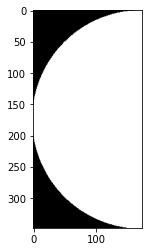

In [29]:
flipped_cir = flip(s2_cir, 1)
plt.imshow(flipped_cir, cmap='gray')

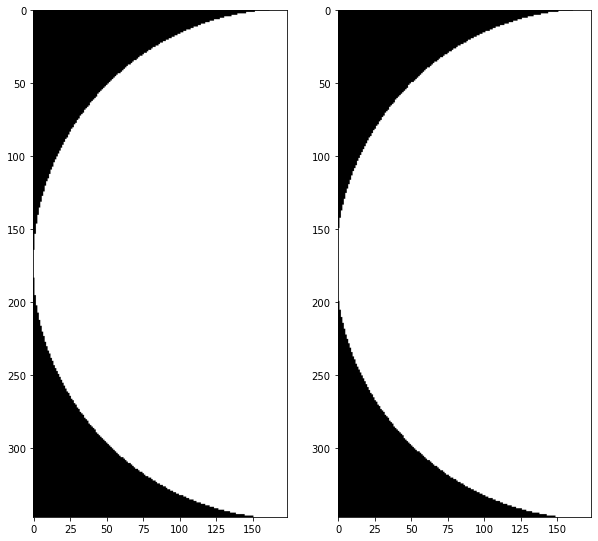

In [30]:
fig, axes = plt.subplots(1, 2, figsize =(10,10))
axes[0].imshow(s1_cir, cmap='gray')
axes[1].imshow(flipped_cir, cmap='gray')

In [ ]:
LR = TestSymmetry(s1_cir, flipped_cir)
print(LR)

494


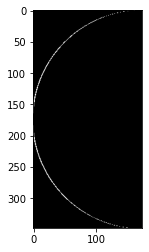

In [31]:
#img_bwa = cv2.bitwise_and(s1,flipped_vertical)
#img_bwo = cv2.bitwise_or(s1,flipped_vertical)
img_bwx = cv2.bitwise_xor(s1_cir,flipped_cir)

#cv2.imshow("Bitwise AND of Image 1 and 2", img_bwa)
#cv2.imshow("Bitwise OR of Image 1 and 2", img_bwo)
plt.imshow(img_bwx, cmap='gray')
number_of_white_pix_im = np.sum(img_bwx == 1)
print(number_of_white_pix_im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### Results: Perimiter 

In [ ]:
feature_data = {"id": image_id, 
                "area": features_area.flatten(),
                "perimeter": features_perimeter.flatten()
                }

df_features = pd.DataFrame(feature_data)
df_features.to_csv(file_features, index=False)   

In [ ]:
# Load the data you saved, then do some analysis
df_features = pd.read_csv(file_features)
image_id = list(df_features['id'])
features_area = np.array(df_features['area'])
features_perimeter = np.array(df_features['perimeter'])

In [ ]:
def scatter_data(x1, x2, y, ax=None):
    # scatter_data displays a scatterplot of featuress x1 and x2, and gives each point
    # a different color based on its label in y

    class_labels, indices1, indices2 = np.unique(y, return_index=True, return_inverse=True)
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.grid()

    colors = cm.rainbow(np.linspace(0, 1, len(class_labels)))
    for i, c in zip(np.arange(len(class_labels)), colors):
        idx2 = indices2 == class_labels[i]
        lbl = 'Class ' + str(i)
        ax.scatter(x1[idx2], x2[idx2], color=c, label=lbl)

    return ax

In [ ]:
# Display the features measured in a scatterplot
axs = scatter_data(features_area, features_perimeter, is_keratosis)
axs.set_xlabel('X1 = Area')
axs.set_ylabel('X2 = Perimeter')
axs.legend()

### Loading raw data

In [ ]:
def load_images_from_folder(folder):
    images = []
    valid_images = [".jpg"]
    for filename in os.listdir(folder):
        ext = os.path.splitext(filename)[1]
        if ext.lower() not in valid_images:
            continue
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def images_id_from_folder(folder): 
    valid_images = [".jpg"]
    onlyfiles = []
    for filename in os.listdir(folder): 
        ext = os.path.splitext(filename)[1]
        if ext.lower() not in valid_images:
            continue
        if os.path.isfile(os.path.join(folder, filename)): 
            onlyfiles.append(filename)
    return onlyfiles

In [ ]:
dataraw = {} 
dataraw["metadata"] = pd.read_csv(PATH["data_raw"]+FILENAME["metadata"])
dataraw["features"] = pd.read_csv(PATH["images_features"]+FILENAME["images_features"])
dataraw["images"] = load_images_from_folder(PATH["images"])
dataraw["images_filename"] = images_id_from_folder(PATH["images"])

## Task 0: Explore the data

In [ ]:
#merging the datasets 
metadata = pd.DataFrame(dataraw["metadata"])
features = pd.DataFrame(dataraw["features"])
merged_data = metadata.merge(features, left_on = ["image_id"], right_on = ["id"])
merged_data = merged_data.drop(["id"], axis =1)
print(merged_data)

In [ ]:
#mask 
mask_melanoma = (merged_data["melanoma"] == 1.0) & (merged_data["seborrheic_keratosis"] == 0.0)
mask_keratosis = (merged_data["melanoma"] == 0.0) & (merged_data["seborrheic_keratosis"] == 1.0)
mask_none = (merged_data["melanoma"] == 0.0) & (merged_data["seborrheic_keratosis"] == 0.0)

merged_melanoma = merged_data[mask_melanoma]
merged_keratosis = merged_data[mask_keratosis]
merged_none = merged_data[mask_none]


In [ ]:
#images id and actual images lists 
melanoma_images_id = [i for i in merged_melanoma["image_id"]]
keratosis_images_id = [i for i in merged_keratosis["image_id"]]
none_images_id = [i for i in merged_none["image_id"]]

melanoma_images = [i for i in dataraw["images_filename"] for j in melanoma_images_id if j in i]
keratosis_images = [i for i in dataraw["images_filename"] for j in keratosis_images_id if j in i]
none_images = [i for i in dataraw["images_filename"] for j in none_images_id if j in i]

NB!    
Only run the next cell once!     
Check interim, if pictures are already sorted, it means that the function has been called 

In [ ]:
#NB!!!! Only 
from shutil import copyfile

subfolder1 = os.path.join(PATH["data_interim"], "melanoma_images")
subfolder2 = os.path.join(PATH["data_interim"], "keratosis_images")
subfolder3 = os.path.join(PATH["data_interim"], "none_images")

if not os.path.exists(subfolder1):
    os.makedirs(subfolder1)

if not os.path.exists(subfolder2):
    os.makedirs(subfolder2)
    
if not os.path.exists(subfolder3):
    os.makedirs(subfolder3)
    
for i in melanoma_images:
    source = os.path.join(PATH["images"], i)
    destination = os.path.join(subfolder1, i)
    copyfile(source, destination)
    
for i in keratosis_images:
    source = os.path.join(PATH["images"], i)
    destination = os.path.join(subfolder2, i)
    copyfile(source, destination)

for i in none_images: 
    source = os.path.join(PATH["images"], i)
    destination = os.path.join(subfolder3, i)
    copyfile(source, destination)